In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import shutil
import os
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from sklearn import preprocessing
from scipy.stats import zscore
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
from skimage import color, exposure, transform

NUM_CLASSES = 26
IMG_SIZE = 200


def preprocess_img_hsv(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img, -1)

    return img


import sys
import cv2

def preprocessing_img_black_and_white(img):
    im_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    skin_ycrcb_mint = np.array((0, 133, 77))
    skin_ycrcb_maxt = np.array((255, 173, 127))
    skin_ycrcb = cv2.inRange(im_ycrcb, skin_ycrcb_mint, skin_ycrcb_maxt)
    return skin_ycrcb

In [3]:
import os

testFiles=[]
trainFiles=[]
for root, dirs, files in os.walk('./data/asl-alphabet/asl_alphabet_train/'):
     for file in files:
            if file.endswith('.jpg'):
                if not file.endswith('_test.jpg'):
                    number=file[1:file.find('.')]
                    if not number.isdigit():
                        continue
                    if(int(number)>50):
                        continue
                file_path = os.path.join(root,file)
                #print(file_path)
                if file.endswith('_test.jpg'):
                    if (not file.startswith('nothing_') and not file.startswith('space_') and not(file.startswith('del_'))):
                        testFiles.append(file_path)
                else:
                    if ((not "nothing" in file) and (not "space" in file) and (not "del" in file)):
                        trainFiles.append(file_path)
testFiles.sort()
trainFiles.sort()
print(len(testFiles))
print(len(trainFiles))

0
1300


In [4]:
#creating the sample set of 20 test images for each alphabet
import os

testFiles=[]

for root, dirs, files in os.walk('./data/asl-alphabet/asl_alphabet_train/'): #asl_alphabet_test_sample
     for file in files:
            if file.endswith('.jpg'):
                if not file.endswith('_test.jpg'):
                    number=file[1:file.find('.')]
                    if not number.isdigit():
                        continue
                    if((int(number)<=50) or int(number)>60):
                        continue
                file_path = os.path.join(root,file)
                #print(file_path)
                if (not file.startswith('nothing_') and not file.startswith('space_') and not(file.startswith('del_'))):
                    testFiles.append(file_path)
                    
testFiles.sort()
trainFiles.sort()
print(len(testFiles))
print(len(trainFiles))

260
1300


In [5]:
from skimage import io
import numpy as np
j=0
# numpy_array_train = np.empty([78000,200,200,3])
x_train = np.empty([1300,200,200])
y_train = []
y_train_for_df = []
alphabet_array = []
alphabet_array.append('A')
alphabet_array.append('B')
alphabet_array.append('C')
alphabet_array.append('D')
alphabet_array.append('E')
alphabet_array.append('F')
alphabet_array.append('G')
alphabet_array.append('H')
alphabet_array.append('I')
alphabet_array.append('J')
alphabet_array.append('K')
alphabet_array.append('L')
alphabet_array.append('M')
alphabet_array.append('N')
alphabet_array.append('O')
alphabet_array.append('P')
alphabet_array.append('Q')
alphabet_array.append('R')
alphabet_array.append('S')
alphabet_array.append('T')
alphabet_array.append('U')
alphabet_array.append('V')
alphabet_array.append('W')
alphabet_array.append('X')
alphabet_array.append('Y')
alphabet_array.append('Z')
k=0
print(len(trainFiles))
for i in trainFiles:    
    x_train[j]=preprocessing_img_black_and_white(io.imread(i))
    j=j+1
    y_train.append(alphabet_array[k])
    if (j%50) == 0: #j%3000 for complete
        k=k+1

print(len(x_train))
print(x_train[1299])

1300
1300
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0. 255. ... 255.   0.   0.]
 ...
 [  0.   0. 255. ...   0. 255.   0.]
 [  0.   0.   0. ... 255.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [6]:
from skimage import io
import numpy as np
j=0
k=0
y_test = []
x_test = np.empty([260,200,200]) 

for i in testFiles:    
    x_test[j]=preprocessing_img_black_and_white(io.imread(i))
    j=j+1
    y_test.append(alphabet_array[k])
    if (j%10) == 0:
        k=k+1


x_test.shape

(260, 200, 200)

In [7]:
y_train_np=np.asarray(y_train)
y_test_np = np.asarray(y_test)
print(x_train.shape)
print(x_test.shape)
print(y_train_np.shape)
print(y_test_np.shape)

(1300, 200, 200)
(260, 200, 200)
(1300,)
(260,)


In [8]:
x_train = x_train.reshape(x_train.shape[0], 200, 200, 1)
x_test = x_test.reshape(x_test.shape[0], 200, 200, 1)


In [9]:
print(x_train.dtype)
print(x_test.dtype)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


float64
float64


In [10]:
# normalize the data values to the range [0, 1]
x_train /= 255
x_test /= 255

In [11]:
#Label Encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train_np)
df_y_train = pd.DataFrame(y_train, columns=['one_hot_encoded'])
encode_text_dummy(df_y_train, 'one_hot_encoded')
y_train = df_y_train.values


y_test = le.fit_transform(y_test_np)
df_y_test = pd.DataFrame(y_test, columns=['one_hot_encoded'])
encode_text_dummy(df_y_test, 'one_hot_encoded')
y_test = df_y_test.values

In [12]:
input_shape = (200, 200, 1)
cnn2d = Sequential()
cnn2d.add(Conv2D(200, kernel_size=(3, 3), strides=(1,1), padding='valid',
                 activation='relu',
                 input_shape=input_shape))  
cnn2d.add(Conv2D(167, (1,2), activation='relu'))
cnn2d.add(Dense(92, activation='relu'))
cnn2d.add(Dropout(0.7))
cnn2d.add(Flatten())
cnn2d.add(Dense(y_train.shape[1], activation='softmax'))
cnn2d.compile(loss='categorical_crossentropy', optimizer='adam')

monitor_cnn = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')
cnn2d.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 200)     2000      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 198, 197, 167)     66967     
_________________________________________________________________
dense_1 (Dense)              (None, 198, 197, 92)      15456     
_________________________________________________________________
dropout_1 (Dropout)          (None, 198, 197, 92)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3588552)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 26)                93302378  
Total params: 93,386,801
Trainable params: 93,386,801
Non-trainable params: 0
________________________________________________________________

In [13]:
import time
from sklearn import metrics

start_time = time.time()

cnn2d.fit(x_train, y_train,     
              epochs=100,
              batch_size = 128,
              verbose=2,
              callbacks=[monitor_cnn],
              validation_data=(x_test, y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 616s - loss: 1.7572 - val_loss: 2.7716
Epoch 2/100
 - 599s - loss: 0.1979 - val_loss: 2.9444
Epoch 3/100
 - 600s - loss: 0.0328 - val_loss: 1.9579
Epoch 4/100
 - 590s - loss: 0.0023 - val_loss: 1.8423
Epoch 5/100
 - 588s - loss: 1.7718e-04 - val_loss: 2.1748
Epoch 6/100
 - 594s - loss: 1.1309e-04 - val_loss: 2.2670
Epoch 7/100
 - 597s - loss: 6.0628e-05 - val_loss: 2.3069
Epoch 8/100
 - 592s - loss: 2.5229e-05 - val_loss: 2.3392
Epoch 9/100
 - 590s - loss: 1.9795e-05 - val_loss: 2.3340
Epoch 00009: early stopping
Elapsed time: 1:29:28.40


In [14]:
from sklearn import metrics

y_true = np.argmax(y_test,axis=1)
cnn_pred = cnn2d.predict(x_test)
cnn_pred = np.argmax(cnn_pred,axis=1)

score = metrics.accuracy_score(y_true, cnn_pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, cnn_pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, cnn_pred))

Accuracy: 0.7538461538461538
Averaged F1: 0.7390270171126244
             precision    recall  f1-score   support

          0       1.00      0.10      0.18        10
          1       0.71      1.00      0.83        10
          2       0.47      0.90      0.62        10
          3       1.00      1.00      1.00        10
          4       1.00      0.50      0.67        10
          5       0.91      1.00      0.95        10
          6       1.00      1.00      1.00        10
          7       0.90      0.90      0.90        10
          8       0.90      0.90      0.90        10
          9       1.00      1.00      1.00        10
         10       1.00      1.00      1.00        10
         11       1.00      1.00      1.00        10
         12       1.00      0.30      0.46        10
         13       0.62      1.00      0.77        10
         14       1.00      1.00      1.00        10
         15       1.00      1.00      1.00        10
         16       1.00      0.20     

In [15]:
y_train_col = le.fit_transform(y_train_np)
df_y_train = pd.DataFrame(y_train_col, columns=['one_hot_encoded'])


<h4>Confusion Matrix: CNN</h4>

Plotting confusion matrix


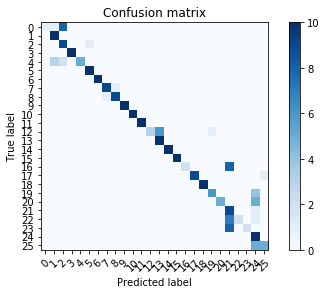

             precision    recall  f1-score   support

          0       1.00      0.10      0.18        10
          1       0.71      1.00      0.83        10
          2       0.47      0.90      0.62        10
          3       1.00      1.00      1.00        10
          4       1.00      0.50      0.67        10
          5       0.91      1.00      0.95        10
          6       1.00      1.00      1.00        10
          7       0.90      0.90      0.90        10
          8       0.90      0.90      0.90        10
          9       1.00      1.00      1.00        10
         10       1.00      1.00      1.00        10
         11       1.00      1.00      1.00        10
         12       1.00      0.30      0.46        10
         13       0.62      1.00      0.77        10
         14       1.00      1.00      1.00        10
         15       1.00      1.00      1.00        10
         16       1.00      0.20      0.33        10
         17       1.00      0.90      0.95   

In [16]:
y_train_class = encode_text_index(df_y_train, 'one_hot_encoded')
#Compute confusion matrix
cm = confusion_matrix(y_true, cnn_pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, y_train_class)
plt.show()

print(classification_report(y_true, cnn_pred))
print("Precision :", metrics.accuracy_score(y_true, cnn_pred))


In [27]:
input_shape = (200, 200, 1)
cnn2d = Sequential()
cnn2d.add(Conv2D(200, kernel_size=(3, 3), strides=(2,2), padding='valid',
                 activation='relu',
                 input_shape=input_shape))  
cnn2d.add(Conv2D(500, (1,2), activation='relu'))

cnn2d.add(Dense(97, activation='relu'))
cnn2d.add(Dense(254, activation='relu'))
cnn2d.add(Dropout(0.2))
cnn2d.add(Dense(134, activation='relu'))
cnn2d.add(Dense(62, activation='relu'))
cnn2d.add(Flatten())


cnn2d.add(Dense(y_train.shape[1], activation='softmax'))
cnn2d.compile(loss='categorical_crossentropy', optimizer='adam')

monitor_cnn = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')
cnn2d.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 99, 99, 200)       2000      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 99, 98, 500)       200500    
_________________________________________________________________
dense_16 (Dense)             (None, 99, 98, 97)        48597     
_________________________________________________________________
dense_17 (Dense)             (None, 99, 98, 254)       24892     
_________________________________________________________________
dropout_7 (Dropout)          (None, 99, 98, 254)       0         
_________________________________________________________________
dense_18 (Dense)             (None, 99, 98, 134)       34170     
_________________________________________________________________
dense_19 (Dense)             (None, 99, 98, 62)        8370      
__________

In [28]:
import time
from sklearn import metrics

start_time = time.time()

cnn2d.fit(x_train, y_train,     
              epochs=100,
              batch_size = 128,
              verbose=2,
              callbacks=[monitor_cnn],
              validation_data=(x_test, y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 308s - loss: 1.5973 - val_loss: 2.6814
Epoch 2/100
 - 302s - loss: 0.1497 - val_loss: 2.3537
Epoch 3/100
 - 299s - loss: 0.0270 - val_loss: 2.5046
Epoch 4/100
 - 301s - loss: 0.0043 - val_loss: 2.3726
Epoch 5/100
 - 300s - loss: 4.0707e-04 - val_loss: 2.6753
Epoch 6/100
 - 304s - loss: 1.0305e-04 - val_loss: 2.6765
Epoch 7/100
 - 305s - loss: 1.0759e-05 - val_loss: 2.6869
Epoch 00007: early stopping
Elapsed time: 0:35:18.72


Accuracy: 0.7115384615384616
Averaged F1: 0.6865758394000987
             precision    recall  f1-score   support

          0       1.00      0.50      0.67        10
          1       0.83      1.00      0.91        10
          2       0.29      0.20      0.24        10
          3       0.48      1.00      0.65        10
          4       1.00      0.60      0.75        10
          5       0.56      0.50      0.53        10
          6       1.00      1.00      1.00        10
          7       1.00      0.80      0.89        10
          8       0.83      1.00      0.91        10
          9       1.00      1.00      1.00        10
         10       1.00      1.00      1.00        10
         11       1.00      1.00      1.00        10
         12       1.00      0.10      0.18        10
         13       0.53      1.00      0.69        10
         14       1.00      1.00      1.00        10
         15       1.00      1.00      1.00        10
         16       0.00      0.00     

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


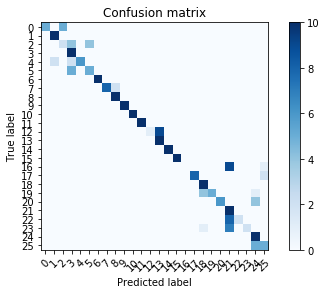

             precision    recall  f1-score   support

          0       1.00      0.50      0.67        10
          1       0.83      1.00      0.91        10
          2       0.29      0.20      0.24        10
          3       0.48      1.00      0.65        10
          4       1.00      0.60      0.75        10
          5       0.56      0.50      0.53        10
          6       1.00      1.00      1.00        10
          7       1.00      0.80      0.89        10
          8       0.83      1.00      0.91        10
          9       1.00      1.00      1.00        10
         10       1.00      1.00      1.00        10
         11       1.00      1.00      1.00        10
         12       1.00      0.10      0.18        10
         13       0.53      1.00      0.69        10
         14       1.00      1.00      1.00        10
         15       1.00      1.00      1.00        10
         16       0.00      0.00      0.00        10
         17       1.00      0.80      0.89   

In [29]:
from sklearn import metrics

y_true = np.argmax(y_test,axis=1)
cnn_pred = cnn2d.predict(x_test)
cnn_pred = np.argmax(cnn_pred,axis=1)

score = metrics.accuracy_score(y_true, cnn_pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, cnn_pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, cnn_pred))



y_train_class = encode_text_index(df_y_train, 'one_hot_encoded')
#Compute confusion matrix
cm = confusion_matrix(y_true, cnn_pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, y_train_class)
plt.show()

print(classification_report(y_true, cnn_pred))
print("Precision :", metrics.accuracy_score(y_true, cnn_pred))


In [30]:
input_shape = (200, 200, 1)
cnn2d = Sequential()
cnn2d.add(Conv2D(200, kernel_size=(10,10), strides=(3,3), padding='valid',
                 activation='relu',
                 input_shape=input_shape))  
cnn2d.add(Conv2D(300, (5,5), activation='relu'))

cnn2d.add(Dense(254, activation='relu'))
cnn2d.add(Dropout(0.1))
cnn2d.add(Dense(134, activation='relu'))
cnn2d.add(Dense(62, activation='relu'))
cnn2d.add(Flatten())


cnn2d.add(Dense(y_train.shape[1], activation='softmax'))
cnn2d.compile(loss='categorical_crossentropy', optimizer='adam')

monitor_cnn = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')
cnn2d.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 64, 200)       20200     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 300)       1500300   
_________________________________________________________________
dense_21 (Dense)             (None, 60, 60, 254)       76454     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 60, 254)       0         
_________________________________________________________________
dense_22 (Dense)             (None, 60, 60, 134)       34170     
_________________________________________________________________
dense_23 (Dense)             (None, 60, 60, 62)        8370      
_________________________________________________________________
flatten_8 (Flatten)          (None, 223200)            0         
__________

In [31]:
import time
from sklearn import metrics

start_time = time.time()

cnn2d.fit(x_train, y_train,     
              epochs=100,
              batch_size = 128,
              verbose=2,
              callbacks=[monitor_cnn],
              validation_data=(x_test, y_test))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 1300 samples, validate on 260 samples
Epoch 1/100
 - 314s - loss: 1.9924 - val_loss: 4.0583
Epoch 2/100
 - 312s - loss: 0.4502 - val_loss: 2.8141
Epoch 3/100
 - 312s - loss: 0.0729 - val_loss: 3.1055
Epoch 4/100
 - 312s - loss: 0.0287 - val_loss: 2.6364
Epoch 5/100
 - 310s - loss: 0.0108 - val_loss: 2.4722
Epoch 6/100
 - 310s - loss: 0.0075 - val_loss: 2.2213
Epoch 7/100
 - 311s - loss: 0.0031 - val_loss: 2.3246
Epoch 8/100
 - 309s - loss: 0.0037 - val_loss: 2.8359
Epoch 9/100
 - 310s - loss: 4.1908e-04 - val_loss: 3.1566
Epoch 10/100
 - 310s - loss: 4.3497e-04 - val_loss: 3.0758
Epoch 11/100
 - 310s - loss: 3.9538e-05 - val_loss: 2.9161
Epoch 00011: early stopping
Elapsed time: 0:57:00.48


Accuracy: 0.7461538461538462
Averaged F1: 0.7130640860512208
             precision    recall  f1-score   support

          0       1.00      0.10      0.18        10
          1       0.77      1.00      0.87        10
          2       0.43      1.00      0.61        10
          3       1.00      0.80      0.89        10
          4       1.00      0.50      0.67        10
          5       1.00      0.90      0.95        10
          6       1.00      1.00      1.00        10
          7       0.91      1.00      0.95        10
          8       1.00      1.00      1.00        10
          9       0.83      1.00      0.91        10
         10       1.00      1.00      1.00        10
         11       1.00      1.00      1.00        10
         12       1.00      0.10      0.18        10
         13       0.53      1.00      0.69        10
         14       1.00      1.00      1.00        10
         15       0.83      1.00      0.91        10
         16       0.00      0.00     

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


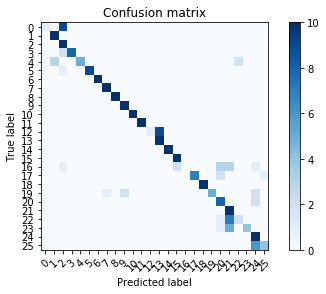

             precision    recall  f1-score   support

          0       1.00      0.10      0.18        10
          1       0.77      1.00      0.87        10
          2       0.43      1.00      0.61        10
          3       1.00      0.80      0.89        10
          4       1.00      0.50      0.67        10
          5       1.00      0.90      0.95        10
          6       1.00      1.00      1.00        10
          7       0.91      1.00      0.95        10
          8       1.00      1.00      1.00        10
          9       0.83      1.00      0.91        10
         10       1.00      1.00      1.00        10
         11       1.00      1.00      1.00        10
         12       1.00      0.10      0.18        10
         13       0.53      1.00      0.69        10
         14       1.00      1.00      1.00        10
         15       0.83      1.00      0.91        10
         16       0.00      0.00      0.00        10
         17       1.00      0.70      0.82   

In [32]:
from sklearn import metrics

y_true = np.argmax(y_test,axis=1)
cnn_pred = cnn2d.predict(x_test)
cnn_pred = np.argmax(cnn_pred,axis=1)

score = metrics.accuracy_score(y_true, cnn_pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, cnn_pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, cnn_pred))



y_train_class = encode_text_index(df_y_train, 'one_hot_encoded')
#Compute confusion matrix
cm = confusion_matrix(y_true, cnn_pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, y_train_class)
plt.show()

print(classification_report(y_true, cnn_pred))
print("Precision :", metrics.accuracy_score(y_true, cnn_pred))
